# ACCESS-OM2 bolus transport and air-sea/mixing fluxes

Analysis of contribution of time-variable flows to temperature-latitude heat budget, overturning, diathermal fluxes

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram

In [2]:
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34811,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:40439,Total threads: 1
Dashboard: /proxy/38589/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:35677,


## Load data files and add some extra information (e.g. binning)

In [3]:
# files:
base = '/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_norediGM/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output086/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
output = 'output086-094_mean'
fwmass_sc = xr.open_mfdataset(base + output + '/ocean_wmass.ncea.nc').chunk({'time': 1,'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_sc = xr.open_mfdataset(base + output + '/ocean_month.ncea.nc').chunk({'time': 1,'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_sc  = xr.open_mfdataset(base + output + '/ocean_heat.ncea.nc').chunk({'time': 1,'yt_ocean':ych,'xt_ocean':xch})
fwmass_mean = xr.open_mfdataset(base + output + '/ocean_wmass.ncea.ncra.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch}).isel(time=0)
fmonth_mean = xr.open_mfdataset(base + output + '/ocean_month.ncea.ncra.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch}).isel(time=0)
fheat_mean = xr.open_mfdataset(base + output + '/ocean_heat.ncea.ncra.nc').chunk({'yt_ocean':ych,'xt_ocean':xch}).isel(time=0)

# Generate xgcm grid object:
gridwm = Grid(fwmass_mean,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_mean,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_mean,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_mean.neutral[1]-fwmass_mean.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extrapolate').rename({'yt_ocean':'grid_yt_ocean'})

In [4]:
# Check netcdf variable chunking:

from netCDF4 import Dataset    

volcgrp = Dataset(base + output + '/ocean_wmass.ncea.nc', 'r')
data = volcgrp.variables['ty_trans_nrho']
print(data.shape)
print(data.chunking())

volcgrp = Dataset(base + output + '/ocean_heat.ncea.nc', 'r')
data = volcgrp.variables['temp_vdiffuse_diff_cbt']
print(data.shape)
print(data.chunking())

volcgrp = Dataset(base + output + '/ocean_month.ncea.nc', 'r')
data = volcgrp.variables['ty_trans']
print(data.shape)
print(data.chunking())

(12, 74, 1080, 1440)
[1, 11, 155, 206]
(12, 50, 1080, 1440)
[1, 8, 180, 240]
(12, 50, 1080, 1440)
[1, 10, 216, 288]


In [5]:
fwmass_mean

<xarray.Dataset>
Dimensions:                         (grid_xt_ocean: 1440, grid_yu_ocean: 1080, neutral: 74, neutralrho_edges: 75, grid_yt_ocean: 1080, nv: 2)
Coordinates:
  * grid_xt_ocean                   (grid_xt_ocean) float64 -279.9 ... 79.88
  * grid_yu_ocean                   (grid_yu_ocean) float64 -81.02 ... 90.0
  * neutral                         (neutral) float64 -2.75 -2.25 ... 33.75
  * neutralrho_edges                (neutralrho_edges) float64 -3.0 ... 34.0
    time                            object 2071-07-01 17:00:00
  * grid_yt_ocean                   (grid_yt_ocean) float64 -81.08 ... 89.95
Dimensions without coordinates: nv
Data variables:
    ty_trans_nrho                   (neutral, grid_yu_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    ty_trans_nrho_submeso           (neutral, grid_yu_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    temp_vdiffuse_diff_cbt_on_nrho  (neutral, grid_yt_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    temp_nonlocal_KPP_on_nrho       (neutral, grid_yt_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    temp_vdiffuse_sbc_on_nrho       (neutral, grid_yt_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    sfc_hflux_pme_on_nrho           (neutral, grid_yt_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    frazil_on_nrho                  (neutral, grid_yt_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    sw_heat_on_nrho                 (neutral, grid_yt_ocean, grid_xt_ocean) float64 dask.array<chunksize=(74, 1080, 1440), meta=np.ndarray>
    time_bounds                     (nv) timedelta64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    temp_numdiff_heat_on_nrho       (neutralrho_edges, grid_yt_ocean, grid_xt_ocean) float32 dask.array<chunksize=(75, 1080, 1440), meta=np.ndarray>
Attributes:
    filename:   ocean_wmass.nc
    title:      ACCESS-OM2-025
    grid_type:  mosaic
    grid_tile:  1
    history:    Mon Jan 10 14:42:00 2022: ncra archive/output086-094_mean/oce...
    NCO:        netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net,...

## Group terms and form Psi, HF, SF, MX calculations:

In [7]:
# Group SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)

fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP

# Group SF and MX terms:
fwmass_sc["SF_cv"] = fwmass_sc.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_sc.sfc_hflux_pme_on_nrho + \
                       fwmass_sc.frazil_on_nrho + \
                       fwmass_sc.sw_heat_on_nrho# + \
#                       fwmass_sc.temp_rivermix_on_nrho
fwmass_sc["MX_cv"] = fwmass_sc.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_sc.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_sc.sfc_hflux_pme,fheat_sc.temp_vdiffuse_sbc)
sfc_hflux_pme_sc = obj.where(fheat_sc.st_ocean==fheat_sc.st_ocean[0],other=0.)

fheat_sc["SF_cv"] = fheat_sc.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_sc + \
                      fheat_sc.frazil_3d + \
                      fheat_sc.sw_heat# + \
#                      fheat_sc.temp_rivermix
fheat_sc["MX_cv"] = fheat_sc.temp_vdiffuse_diff_cbt + \
                      fheat_sc.temp_nonlocal_KPP 

In [8]:
# temperature binning of time-mean:

# transport
temp_u_mean = gridmn.interp(fmonth_mean.temp,'y',boundary='extend')-273.15
fwmass_mean["ty_trans_nrho_mean"] = gridmn.transform(fmonth_mean.ty_trans,'z',fwmass_mean.neutralrho_edges,method='conservative',target_data=temp_u_mean).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# SF and MX:
fwmass_mean["SF_cv_mean"] = gridht.transform(fheat_mean.SF_cv,'z',fwmass_mean.neutralrho_edges,method='conservative',target_data=fmonth_mean.temp-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["MX_cv_mean"] = gridht.transform(fheat_mean.MX_cv,'z',fwmass_mean.neutralrho_edges,method='conservative',target_data=fmonth_mean.temp-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

In [9]:
# temperature binning of Seasonal cycle:

# transport
temp_u_sc = gridmn.interp(fmonth_sc.temp,'y',boundary='extend')-273.15
fwmass_sc["ty_trans_nrho_sc"] = gridmn.transform(fmonth_sc.ty_trans,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=temp_u_sc).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# SF and MX:
fwmass_sc["SF_cv_sc"] = gridht.transform(fheat_sc.SF_cv,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=fmonth_sc.temp-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_sc["MX_cv_sc"] = gridht.transform(fheat_sc.MX_cv,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=fmonth_sc.temp-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

In [11]:
# True streamfunction and heat function:
Psi = gridwm.cumsum(fwmass_mean.ty_trans_nrho.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0

# True surface forcing and vertical mixing:
SF = -gridwm.cumsum((fwmass_mean.SF_cv*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy
MX = -gridwm.cumsum((fwmass_mean.MX_cv*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy

In [12]:
# Same for time-mean:
Psi_mean = gridwm.cumsum(fwmass_mean.ty_trans_nrho_mean.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0

# True surface forcing and vertical mixing:
SF_mean = -gridwm.cumsum((fwmass_mean.SF_cv_mean*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy
MX_mean = -gridwm.cumsum((fwmass_mean.MX_cv_mean*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy

In [13]:
# Same for Seasonal Cycle:
Psi_sc = gridwm.cumsum(fwmass_sc.ty_trans_nrho_sc.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0

# True surface forcing and vertical mixing:
SF_sc = -gridwm.cumsum((fwmass_sc.SF_cv_sc*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy
MX_sc = -gridwm.cumsum((fwmass_sc.MX_cv_sc*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy

In [14]:
# Do the operations:
# Lagrangian:
Psi.load();
SF.load();
MX.load();

In [15]:
# Mean binned:
Psi_mean.load();
SF_mean.load();
MX_mean.load();

In [16]:
# Seasonal cycle binned:
# This is done on 12 months of data, and blows-up the memory. Hence split into 1 month sections:
Psi_sc_timemean = xr.zeros_like(Psi_sc.isel(time=0))
nt = len(sc_daylength)
for i in range(nt):
    print('Doing time step ' + str(i+1) + ' of ' + str(nt))
    Psi_sc_t = Psi_sc.isel(time=i);
    Psi_sc_t.load()
    Psi_sc_timemean += Psi_sc_t*sc_daylength[i]
Psi_sc_timemean = Psi_sc_timemean/np.sum(sc_daylength)
Psi_sc = Psi_sc_timemean

Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12
Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12


In [17]:
SF_sc_timemean = xr.zeros_like(SF_sc.isel(time=0))
nt = len(sc_daylength)
for i in range(nt):
    print('Doing time step ' + str(i+1) + ' of ' + str(nt))
    SF_sc_t = SF_sc.isel(time=i);
    SF_sc_t.load()
    SF_sc_timemean += SF_sc_t*sc_daylength[i]
SF_sc_timemean = SF_sc_timemean/np.sum(sc_daylength)
SF_sc = SF_sc_timemean

Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12
Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12


In [18]:
MX_sc_timemean = xr.zeros_like(MX_sc.isel(time=0))
nt = len(sc_daylength)
for i in range(nt):
    print('Doing time step ' + str(i+1) + ' of ' + str(nt))
    MX_sc_t = MX_sc.isel(time=i);
    MX_sc_t.load()
    MX_sc_timemean += MX_sc_t*sc_daylength[i]
MX_sc_timemean = MX_sc_timemean/np.sum(sc_daylength)
MX_sc = MX_sc_timemean

Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12
Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12


In [19]:
# Calculate heat functions (do after load commands since it's only a 2D operation):
Hf = -Cp*rho0*dT*gridwm.cumsum(Psi,'T',boundary="fill", fill_value=0)
Hf_mean = -Cp*rho0*dT*gridwm.cumsum(Psi_mean,'T',boundary="fill", fill_value=0)
Hf_sc = -Cp*rho0*dT*gridwm.cumsum(Psi_sc,'T',boundary="fill", fill_value=0)

In [20]:
# Calculate seasonal cycle by residual:
Psi_ac = Psi_sc-Psi_mean;
Hf_ac = Hf_sc-Hf_mean;
SF_ac = SF_sc-SF_mean;
MX_ac = MX_sc-MX_mean;

In [21]:
# Calculate eddy terms by residual:
Psi_eddy = Psi-Psi_ac-Psi_mean;
Hf_eddy = Hf-Hf_ac-Hf_mean;
SF_eddy = SF-SF_ac-SF_mean;
MX_eddy = MX-MX_ac-MX_mean;

In [22]:
# masking:
maskPsi = 0*Psi.where(Psi!=Psi.isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

<xarray.DataArray (neutralrho_edges: 75, grid_yt_ocean: 1080)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95

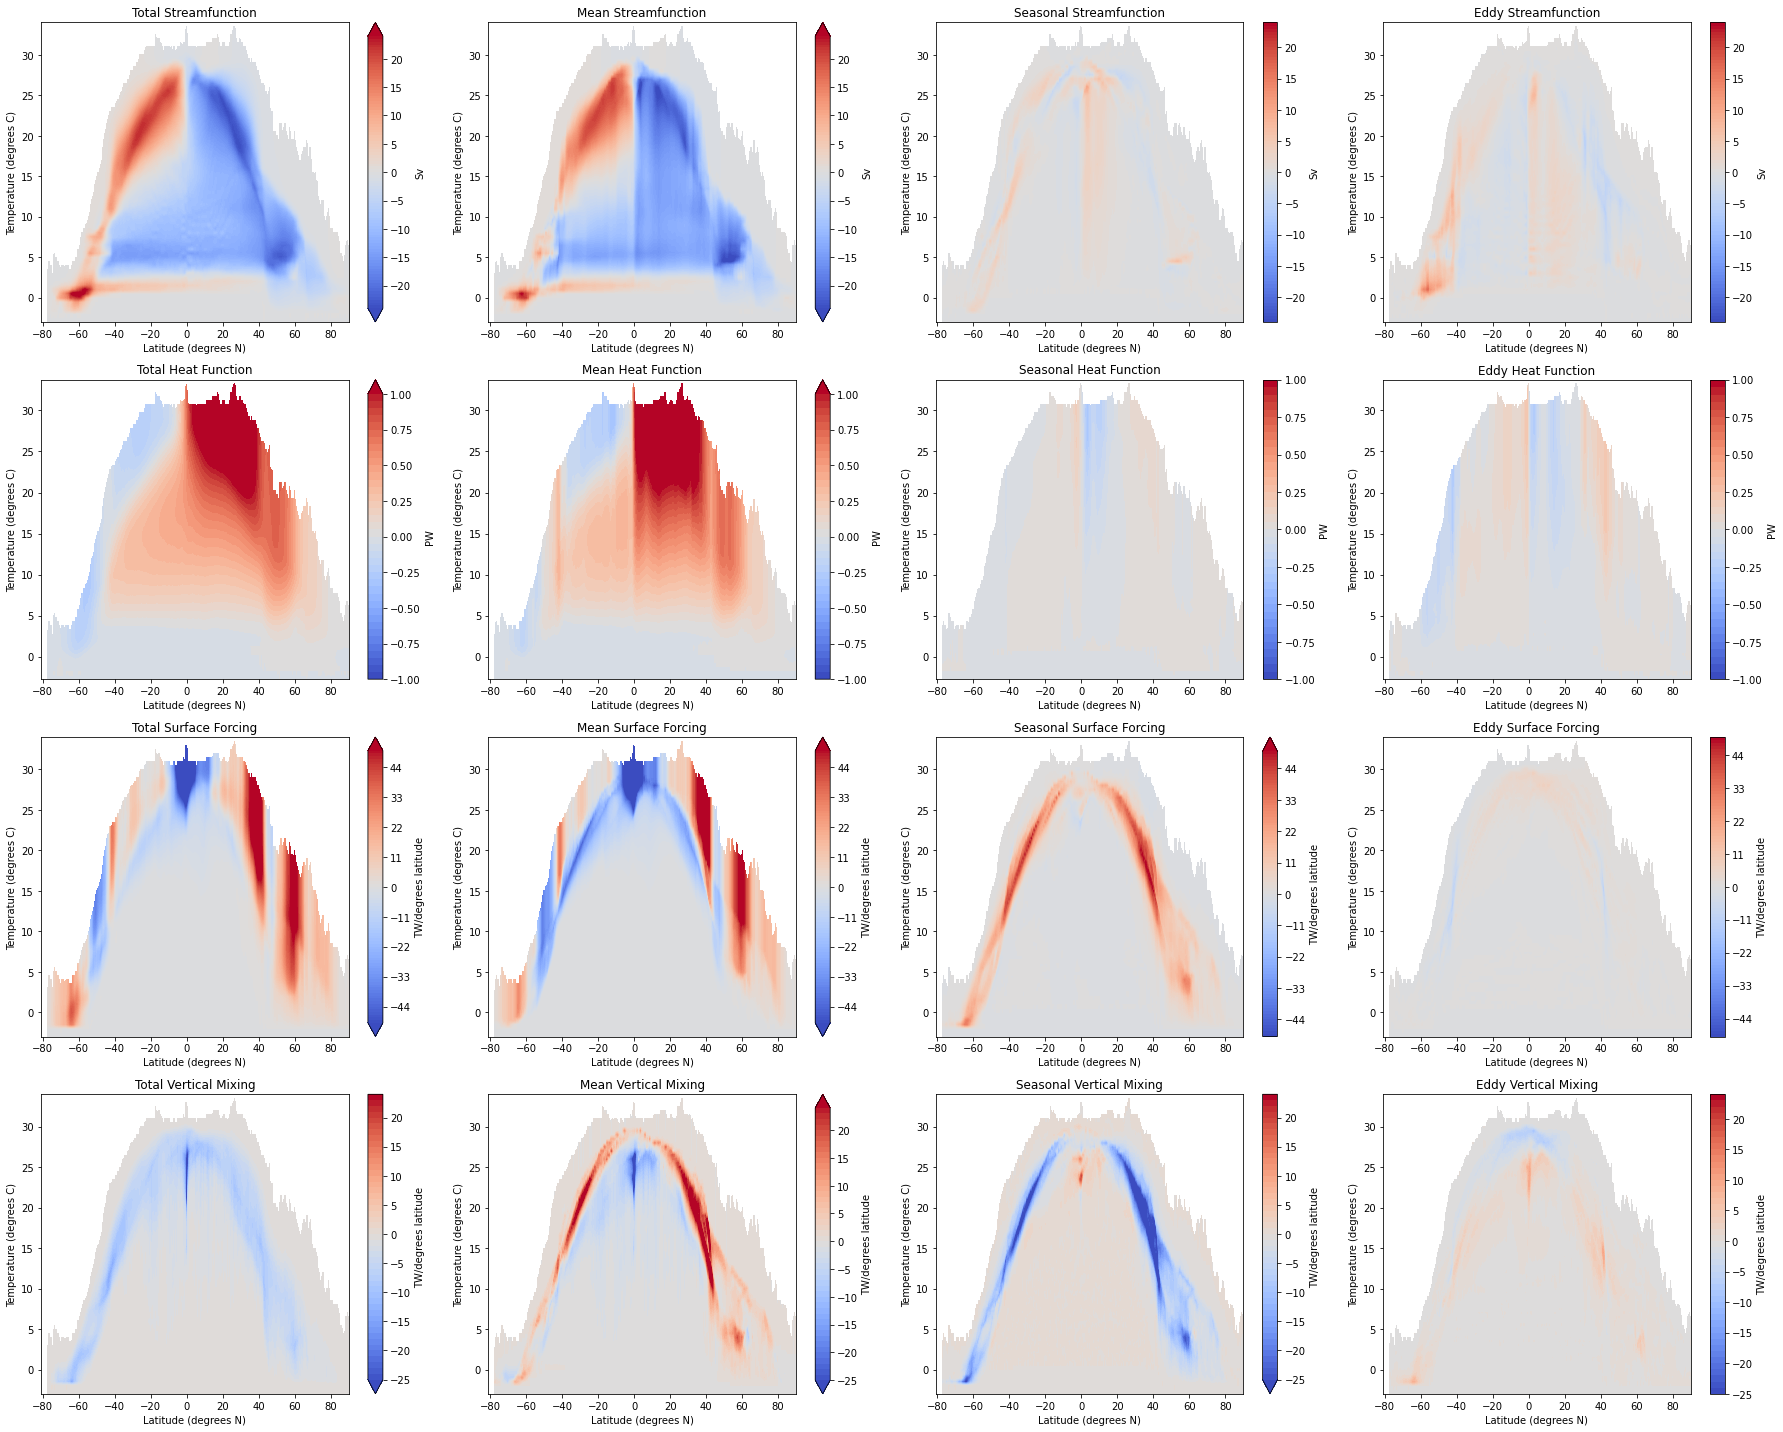

In [25]:
# Plotting:
plt.figure(figsize=(25,20),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = False
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-10.,10.2,0.2)
    MXcbar_sc = np.arange(-5.,5.2,0.2)
    Psicbar_e = np.arange(-10.,10.1,0.1)
    Hfcbar_e = np.arange(-0.2,0.21,0.01)
    SFcbar_e = np.arange(-10.,10.2,0.2)
    MXcbar_e = np.arange(-5.,5.2,0.2)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar

plt.subplot(4,4,1)
(Psi.where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('Total Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,2)
(Psi_mean.where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('Mean Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,3)
(Psi_ac.where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_sc,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('Seasonal Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,4)
(Psi_eddy.where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_e,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('Eddy Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,5)
(Hf.where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('Total Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,6)
(Hf_mean.where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('Mean Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,7)
(Hf_ac.where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_sc,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('Seasonal Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,8)
(Hf_eddy.where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_e,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('Eddy Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,9)
(SF.where(maskSF==1.)/1.e12).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Total Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,10)
(SF_mean.where(maskSF==1.)/1.e12).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Mean Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,11)
(SF_ac.where(maskSF==1.)/1.e12).plot.contourf(levels=SFcbar_sc,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Seasonal Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,12)
(SF_eddy.where(maskSF==1.)/1.e12).plot.contourf(levels=SFcbar_e,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Eddy Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,13)
(MX.where(maskSF==1.)/1.e12).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Total Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,14)
(MX_mean.where(maskSF==1.)/1.e12).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Mean Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,15)
(MX_ac.where(maskSF==1.)/1.e12).plot.contourf(levels=MXcbar_sc,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Seasonal Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,16)
(MX_eddy.where(maskSF==1.)/1.e12).plot.contourf(levels=MXcbar_e,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Eddy Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.tight_layout()
plt.savefig('ACCESS-OM2-025_norediGM_TotalMeanSeasonalEddy_SfHfSFMX.png',dpi=100,bbox_inches='tight')

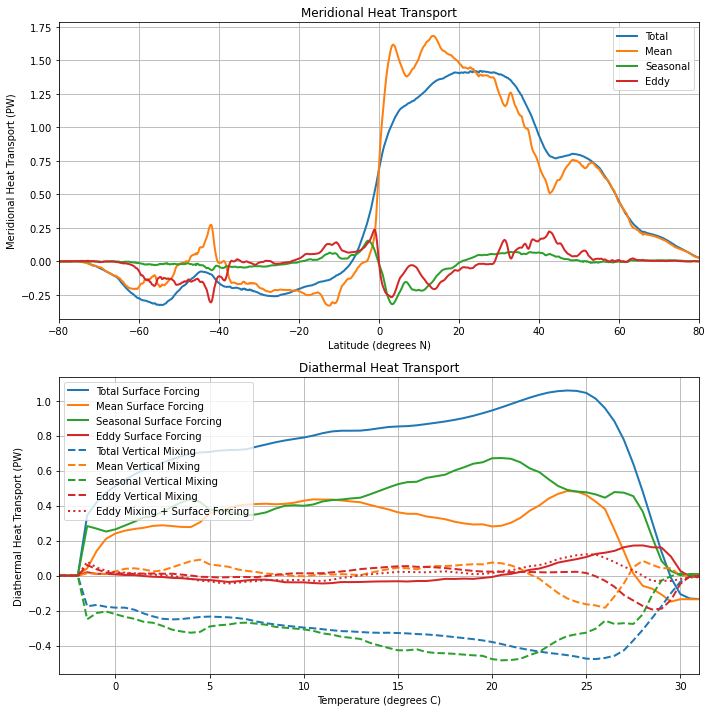

In [29]:
# Totals in temperature and meridional directions:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
(Hf/1.e15).isel(neutral=-1).plot(label='Total',linewidth=2)
(Hf_mean/1.e15).isel(neutral=-1).plot(label='Mean',linewidth=2)
(Hf_ac/1.e15).isel(neutral=-1).plot(label='Seasonal',linewidth=2)
(Hf_eddy/1.e15).isel(neutral=-1).plot(label='Eddy',linewidth=2)
plt.legend()
plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('Meridional Heat Transport')
plt.grid()
plt.xlim([-80.,80.])

plt.subplot(2,1,2)
(SF*dy/1.e15).sum('grid_yt_ocean').plot(label='Total Surface Forcing',color='C0',linewidth=2)
(SF_mean*dy/1.e15).sum('grid_yt_ocean').plot(label='Mean Surface Forcing',color='C1',linewidth=2)
(SF_ac*dy/1.e15).sum('grid_yt_ocean').plot(label='Seasonal Surface Forcing',color='C2',linewidth=2)
(SF_eddy*dy/1.e15).sum('grid_yt_ocean').plot(label='Eddy Surface Forcing',color='C3',linewidth=2)
(MX*dy/1.e15).sum('grid_yt_ocean').plot(label='Total Vertical Mixing',color='C0',linestyle='dashed',linewidth=2)
(MX_mean*dy/1.e15).sum('grid_yt_ocean').plot(label='Mean Vertical Mixing',color='C1',linestyle='dashed',linewidth=2)
(MX_ac*dy/1.e15).sum('grid_yt_ocean').plot(label='Seasonal Vertical Mixing',color='C2',linestyle='dashed',linewidth=2)
(MX_eddy*dy/1.e15).sum('grid_yt_ocean').plot(label='Eddy Vertical Mixing',color='C3',linestyle='dashed',linewidth=2)
((MX_eddy+SF_eddy)*dy/1.e15).sum('grid_yt_ocean').plot(label='Eddy Mixing + Surface Forcing',color='C3',linestyle='dotted',linewidth=2)
plt.legend(loc='upper left')
plt.ylabel('Diathermal Heat Transport (PW)')
plt.xlabel('Temperature (degrees C)')
plt.title('Diathermal Heat Transport')
plt.grid()
plt.xlim([-3.,31.])

plt.tight_layout()
plt.savefig('ACCESS-OM2-025_norediGM_TotalMeanSeasonalEddy_SfHfSFMX_MHT_and_DHT.png',dpi=100,bbox_inches='tight')

## Summary:
- Both seasonal and eddy components of MHT are significant (e.g. reaching ~=0.25PW, compared to 1-1.5 peaks in mean).Seasonal is strong near the equator (fluxes toward equator), eddy is significant here as well as at higher latitudes.
- Total surface forcing is roughly 50% seasonal, 50% mean. Eddy component is smaller but significant (and positive) at warmer temperatures.
- Total vertical mixing is predominantly seasonal. Eddy component is significant at warmer temperatures.
- Big compensation between seasonal surface forcing and mixing in lat-theta. why? and why the signs???
## Problems/to do:
- Numerical mixing term -> This is tricky because I need the "Eulerian" numerical mixing tendency source, and then bin it using average temperatures. How do I get this?
- Close the budget again - should be easy, include the small terms + tendency (tendency is just standard average snapshot difference drift).
- Think about how these vary over ENSO/interannual-decadal variability events -> you'll still have a mean, and a seasonal. How does the eddy term vary with ENSO? How does tendency and what is the best way to deal with the variability - think of it as another rectification/bolus term or treat it using the tendency?
## Comparison with ROMS:
- ROMS (SAPEQ July-December average) has much strong TIWs and eddy overturning near the equator, with a peak eddy overturning of ~20Sv near 25C, 3N (compared to ~7Sv in OM2), peak eddy MHT of up to 0.5Sv (compared to 0.25Sv).
- There are also strong differences in eddy surface forcing; this is small (up to maybe 12TW/deg lat) and negative in ROMS, but always positive and large in OM2.
- The eddy vertical mixing shows some similarities; with negative at warm temps and positive at colder temps.
These patterns need to be understood...

In [6]:
# Quick plot of SST and surface heat flux for seasonal recitification:
# files:
base = '/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_norediGM/';
output = 'output086-094_mean'
fmonth_sc = xr.open_mfdataset(base + output + '/ocean_month.ncea.nc')

reg = (-200.,-130.,20.,40.)

SST = fmonth_sc.temp.isel(st_ocean=0).sel(xt_ocean=slice(reg[0],reg[1])).sel(yt_ocean=slice(reg[2],reg[3])).mean('xt_ocean').mean('yt_ocean')
Q = fmonth_sc.net_sfc_heating.sel(xt_ocean=slice(reg[0],reg[1])).sel(yt_ocean=slice(reg[2],reg[3])).mean('xt_ocean').mean('yt_ocean')

SST.load()
Q.load()

<xarray.DataArray 'net_sfc_heating' (time: 12)>
array([ -85.247856,  -69.51865 ,  -12.176709,   66.327835,   81.68237 ,
         91.39612 ,   95.00394 ,   60.996613,   22.556814,  -34.166256,
       -132.88014 , -110.823875], dtype=float32)
Coordinates:
  * time     (time) object 2071-01-16 12:00:00 ... 2071-12-16 12:00:00

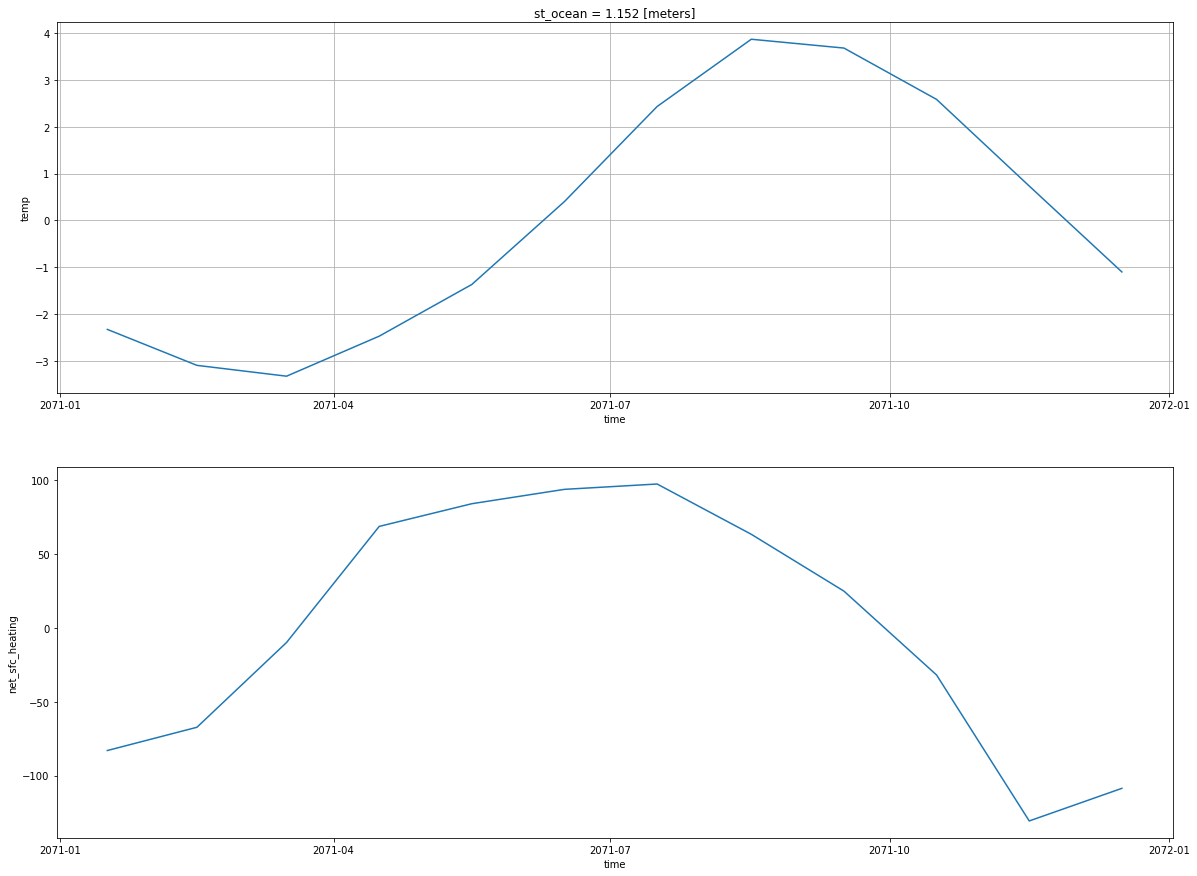

In [9]:
plt.figure(figsize=(20,15),facecolor='w')


#plt.subplot(2,2,1)
#fmonth_sc.temp.isel(st_ocean=0).isel(time=0).plot()
#plt.plot([reg[0],reg[1],reg[1],reg[0],reg[0]],[reg[2],reg[2],reg[3],reg[3],reg[2]],'-k')

plt.subplot(2,1,1)
(SST-SST.mean('time')).plot()
plt.grid()
plt.subplot(2,1,2)
(Q-Q.mean('time')).plot()

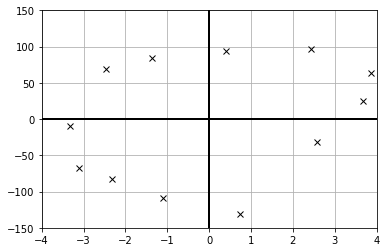

In [18]:
plt.plot((SST-SST.mean()),(Q-Q.mean()),'xk')
plt.plot([-4., 4.],[0., 0.],'-k',linewidth=2)
plt.plot([0., 0.],[-150.,150.],'-k',linewidth=2)
plt.xlim([-4.,4.])
plt.ylim([-150.,150.])
plt.grid()